<a href="https://colab.research.google.com/github/w3gilberto/projetoSRI/blob/main/en_Projeto_SRI_GilbertoRamos___Gensim_word2vec_reviews_airbnb_Rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto da Disciplina SRI - Prof Flávio Codeço Coelho - Aluno: Gilberto Ramos - 30.11.2021
## Análise textual e de similaridades de palavras em avaliações de hóspedes no Airbnb usando Gensim-Word2vec e SpaCy.



In [77]:
import pandas as pd
pd.options.mode.chained_assignment = None #suppresses the warning.
import matplotlib.pyplot as plt
#plotagem interativa
%matplotlib notebook 
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') #disable warnings
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm
#from gensim.models.tfidfmodel import TfidfModel
import nltk
nltk.download('stopwords')
import spacy.cli 
spacy.cli.download("pt_core_news_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


# Fonte do Dataset Airbnb Rio de Janeiro - reviews de 2010 a 2021

fonte do Dataset: Kaggle 
https://www.kaggle.com/vabatista/airbnb-rio-de-janeiro?select=reviews.csv


In [78]:
from google.colab import files 
uploaded = files.upload()
df = pd.read_csv('reviews_airbnb_Rio_.csv')



Saving reviews_airbnb_Rio_.csv to reviews_airbnb_Rio_ (2).csv


In [79]:
df.head(20)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,17878,64852,2010-07-15,135370,Tia,This apartment is in a perfect location -- two...
1,17878,76744,2010-08-11,10206,Mimi,we had a really great experience staying in Ma...
2,17878,91074,2010-09-06,80253,Jan,Staying in Max appartment is like living in a ...
3,17878,137528,2010-11-12,230449,Orene,In general very good and reasonable price.\r\n...
4,17878,147594,2010-12-01,219338,David,The apt was nice and in a great location only ...
5,17878,152368,2010-12-12,266847,Armi,At Copacabana apartment is best the situation ...
6,17878,155565,2010-12-19,243287,Jonathan,A great apartment in a great location. The clo...
7,17878,179219,2011-02-07,172558,Anna,Apartment is exactly as Max advertised. If we ...
8,17878,186447,2011-02-22,353604,Remy,"Great apartment, amazing price and location in..."
9,17878,191020,2011-03-01,122909,Cliff,Max was very organised and understanding to al...


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16131 entries, 0 to 16130
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     16131 non-null  int64 
 1   id             16131 non-null  int64 
 2   date           16131 non-null  object
 3   reviewer_id    16131 non-null  int64 
 4   reviewer_name  16131 non-null  object
 5   comments       16129 non-null  object
dtypes: int64(3), object(3)
memory usage: 756.3+ KB


In [81]:
df.shape

(16131, 6)

In [82]:
df.isna().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         2
dtype: int64

**Pré-processamento**

In [83]:
dummy_data = df[['date','reviewer_name','comments']]

concatenando em novo campo 'text' = 'reviewer_name' + 'comments' 

In [84]:
dummy_data['text'] = dummy_data['reviewer_name'] + ' ' + dummy_data['comments']
dummy_data = dummy_data.drop(['reviewer_name', 'comments'], axis=1)
dummy_data.head()

,date,text
0,2010-07-15,Tia This apartment is in a perfect location --...
1,2010-08-11,Mimi we had a really great experience staying ...
2,2010-09-06,Jan Staying in Max appartment is like living i...
3,2010-11-12,Orene In general very good and reasonable pric...
4,2010-12-01,David The apt was nice and in a great location...


# **limpeza do texto**

lematizando e removendo as palavras irrelevantes e os caracteres não alfabéticos de cada linha.

Para isso, estamos usando SpaCy e seu pipeline integrado.

In [85]:
#nlp = spacy.load("pt_core_news_sm", disable=['ner', 'parser']) # desabilitando o reconhecimento de entidade nomeada para acelerar
nlp = spacy.load("en", disable=['ner', 'parser'])

def cleaning(doc):
    #remove stopwords + Lemmatização 
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # word2vec usa palavras de contexto para aprender a representação vetorial de uma palavra target
    # se a frase tiver apenas uma ou duas palavras,
    # o benefício para treiná-los é pequeno, portanto, podemos descartá-los 
    if len(txt)>2:
        return ' '.join(txt)

**Removendo caracteres diferentes de caracteres alfanuméricos**

In [86]:
init_cleaning = (re.sub("[^A-Za-z]+",' ',str(row)).lower() for row in dummy_data['text'])

**Aproveitando o atributo spaCy .pipe () para acelerar o processo de limpeza:**

In [87]:
t = time()

#tamanho do batch usado: se um documento tiver mais de 1.000 palavras, tratá-lo como um documento separado
txt = [cleaning(doc) for doc in nlp.pipe(init_cleaning,batch_size=1000,n_threads=-1)]

print('Tempo de duração da limpeza: {} mins'.format(round((time() - t)/60,2)))

Tempo de duração da limpeza: 0.57 mins


**dados limpos:**

Agora que limpamos os dados, vamos armazená-los em um novo dataframe e eliminar quaisquer valores nulos / ausentes ou duplicatas

In [88]:
df_clean = pd.DataFrame({'clean':txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(16004, 1)

**Bigramas**

Estamos usando o pacote Gensim Phrases para detectar automaticamente frases comuns (bigramas) de uma lista de frases/sentenças.

In [89]:
from gensim.models.phrases import Phrases,Phraser

Phrases() recebe uma **lista de lista** de palavras como entrada

In [90]:
sent = [row.split() for row in df_clean['clean']]

Cria as frases/sentenças relevantes da lista de frases/sentenças:

In [91]:
phrases = Phrases(sent,min_count=30, progress_per=10000)

INFO - 17:39:46: collecting all words and their counts
INFO - 17:39:46: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:39:47: PROGRESS: at sentence #10000, processed 401669 words and 205718 word types
INFO - 17:39:47: collected 293720 word types from a corpus of 652618 words (unigram + bigrams) and 16004 sentences
INFO - 17:39:47: using 293720 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


O objetivo de **Phraser** () é reduzir o consumo de memória de *Phrases* (), descartando o estado do modelo não estritamente necessário para a tarefa de detecção de bigrama:

In [92]:
bigram = Phraser(phrases)

INFO - 17:39:56: source_vocab length 293720
INFO - 17:39:59: Phraser built with 583 phrasegrams


Transformar o **corpus** com base nos bigramas detectados:

In [93]:
sentences = bigram[sent]

**Palavras mais frequentes:**

verificação de integridade da eficácia da ***lematização***, remoção de palavras irrelevantes e adição de bigramas.

In [94]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

30723

In [95]:
print(sentences[5676])

['david', 'stay', 'night', 'wife', 'self', 'check', 'perfect', 'arrive_late', 'night', 'location', 'excellent', 'walk_distance', 'beach', 'bar', 'etc', 'quiet_street']


In [97]:
print(bigram[sentences[1239]])

['andr', 'apartamento', 'bem_localizado', 'pr_ximo', 'praia', 'e', 'ao', 'com_rcio', 'supermercado', 'farm_cia', 'bare_restaurante', 'caf', 's', 'ambiente', 'limpo_e', 'com', 'porteiros', 'muito', 'educados', 'fizemo', 'o', 'check', 'tardio', 'por', 'volta', 'das', 'sem', 'custo', 'adicional', 'o', 'anfitri', 'o', 'disponibilizou', 'um', 'n', 'mero', 'privado', 'de', 'contato', 'para', 'qualquer', 'esclarecimento', 'ou', 'contratempo', 'e', 'um', 'mapa', 'com', 'os', 'locais', 'que', 'possivelmente', 'usar', 'amos', 'nico', 'ponto', 'melhorar', 'seria', 'disponibilizar', 'mais', 'travesseiros']


In [98]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['de', 'e', 'o', 'apartment', 's', 'y', 'rio', 'stay', 'que', 'place']

**Treinando o modelo**

Usamos a implementação Gensim de word2vec. 
O **Word2vec** é um método para criar de maneira eficiente a incorporação de palavras

In [99]:
import multiprocessing
from gensim.models import Word2Vec

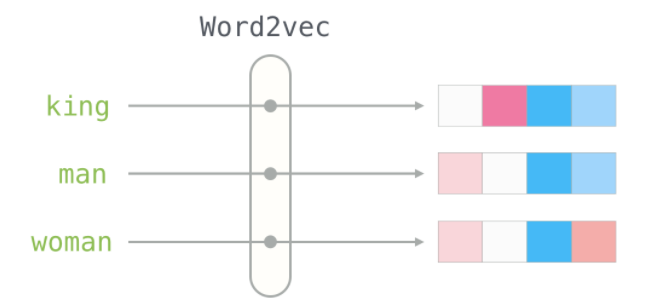

**Modelo em 3 etapas:**

**Word2Vec ():**
Nesta primeira etapa, configuramos os parâmetros do modelo.


**build_vocab ():**
constrói o vocabulário a partir de uma sequência de frases e, assim, inicializa o modelo.
Com os registros, posso acompanhar o progresso e, ainda mais importante, o efeito de min_count e sample no **corpus** de palavras.

**train():**
Por fim, treina o modelo.
Os registros aqui são principalmente úteis para monitoramento.

In [100]:
#Conta o número de núcleos(cores) em uma máquina
cores = multiprocessing.cpu_count() 

In [101]:
print(cores)

2


**Os parâmetros :**

**min_count** = int - Ignora todas as palavras com frequência absoluta total inferior a esta - (2, 100)

**window** = int - A distância máxima entre a palavra atual e a prevista em uma frase. Por exemplo. palavras da janela à esquerda e palavras da janela à direita do nosso alvo - (2, 10)

**size** = int - Dimensionalidade dos vetores de recursos. - (50, 300) 

**negative** = int - Se> 0, a amostragem negativa será usada, o int para negativo especifica quantas "palavras de ruído" devem ser eliminadas. Se definido como 0, nenhuma amostra negativa é usada. - (5, 20)

**workers** = int - threads de trabalho para treinar o modelo (= treinamento mais rápido com máquinas multicore)

In [102]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

**Construindo a Tabela de Vocabulário:**

O Word2Vec exige que construamos a tabela de vocabulário (simplesmente digerindo todas as palavras e filtrando as palavras únicas e fazendo algumas contagens básicas com elas):

In [103]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('tempo gasto p/ construir o vocabulário: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:43:58: collecting all words and their counts
INFO - 17:43:58: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:44:00: PROGRESS: at sentence #10000, processed 363751 words, keeping 24225 word types
INFO - 17:44:00: collected 30723 word types from a corpus of 589816 raw words and 16004 sentences
INFO - 17:44:00: Loading a fresh vocabulary
INFO - 17:44:00: effective_min_count=20 retains 3569 unique words (11% of original 30723, drops 27154)
INFO - 17:44:00: effective_min_count=20 leaves 511401 word corpus (86% of original 589816, drops 78415)
INFO - 17:44:00: deleting the raw counts dictionary of 30723 items
INFO - 17:44:00: sample=6e-05 downsamples 1221 most-common words
INFO - 17:44:00: downsampling leaves estimated 238863 word corpus (46.7% of prior 511401)
INFO - 17:44:01: estimated required memory for 3569 words and 300 dimensions: 10350100 bytes
INFO - 17:44:01: resetting layer weights


tempo gasto p/ construir o vocabulário: 0.05 mins


# **Treinamento do modelo:**

Parâmetros do treinamento:

**total_examples** = int - Contagem de sentenças;

**epochs** = int - Número de iterações (epochs) no **corpus** - [10, 20, 30]

In [104]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('tempo gasto p/ treinar o modelo: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:44:28: training model with 1 workers on 3569 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=5
INFO - 17:44:29: EPOCH 1 - PROGRESS: at 29.87% examples, 72024 words/s, in_qsize 0, out_qsize 0
INFO - 17:44:30: EPOCH 1 - PROGRESS: at 63.39% examples, 74114 words/s, in_qsize 0, out_qsize 0
INFO - 17:44:31: EPOCH 1 - PROGRESS: at 94.80% examples, 74904 words/s, in_qsize 1, out_qsize 0
INFO - 17:44:31: worker thread finished; awaiting finish of 0 more threads
INFO - 17:44:31: EPOCH - 1 : training on 589816 raw words (239025 effective words) took 3.1s, 76286 effective words/s
INFO - 17:44:32: EPOCH 2 - PROGRESS: at 31.34% examples, 72371 words/s, in_qsize 0, out_qsize 0
INFO - 17:44:33: EPOCH 2 - PROGRESS: at 66.50% examples, 75381 words/s, in_qsize 0, out_qsize 0
INFO - 17:44:34: EPOCH 2 - PROGRESS: at 99.50% examples, 77121 words/s, in_qsize 1, out_qsize 0
INFO - 17:44:34: worker thread finished; awaiting finish of 0 more threads
INFO - 17:44:34: EPOCH

tempo gasto p/ treinar o modelo: 2.02 mins


**o modelo foi treinado com 16004 exemplos**

In [105]:
total_examples=w2v_model.corpus_count
print(total_examples)

16004


**Explorando o modelo**

**most_similar**(): Aqui, pediremos ao nosso modelo para encontrar as 10 palavras mais semelhante a 'preço' dentre as palavras no **corpus**

In [106]:
w2v_model.wv.most_similar(positive=["price"])

INFO - 17:46:32: precomputing L2-norms of word weight vectors


[('reasonable', 0.8924930095672607),
 ('expensive', 0.8604773283004761),
 ('benefit', 0.8429152965545654),
 ('rate', 0.8151706457138062),
 ('compare', 0.8134225606918335),
 ('value', 0.7950630784034729),
 ('star', 0.7895233631134033),
 ('value_money', 0.7885353565216064),
 ('cleanliness', 0.7873445749282837),
 ('good_value', 0.7821454405784607)]

# **visualização com t-SNE:**

t-SNE é um algoritmo de redução de dimensionalidade não linear que tenta representar dados de alta dimensão e as relações subjacentes entre vetores em um espaço de dimensão inferior.

In [107]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Para tornar as visualizações mais relevantes, examinaremos as relações entre uma palavra de consulta (em **vermelho**), suas palavras mais semelhantes no modelo (em **azul**) e outras palavras do vocabulário (em **verde**).

In [108]:
def tsnescatterplot(model, word, list_names):
    """ Plotando com seaborn os resultados do algoritmo de redução de dimensionalidade t-SNE dos vetores de uma palavra de consulta,
    sua lista de palavras mais semelhantes e uma lista de palavras
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adiciona o vetor da palavra de consulta
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # obtém a lista das palavras mais semelhantes
    close_words = model.wv.most_similar([word])
    
    # adiciona o vetor para cada uma das palavras mais próximas da matriz
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adiciona o vetor para cada uma das palavras de list_names ao array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduz a dimensionalidade de 300 para 50 dimensões com PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Encontra coordenadas t-SNE para 2 dimensões
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # configurando o plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # plot básico
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adiciona anotações uma a uma com um loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

Vamos verificar as 20 palavras semelhantes a '**preço**' e traçá-las.

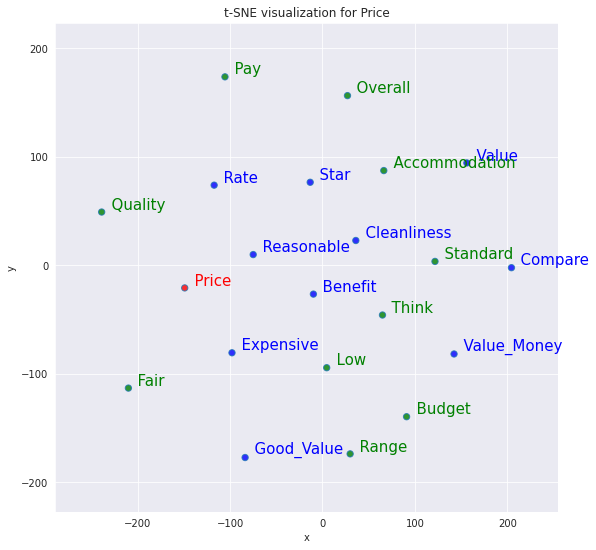

In [109]:
tsnescatterplot(w2v_model, 'price',[t[0] for t in w2v_model.wv.most_similar(positive=["price"], topn=20)][10:])

Vamos ver a diferença com as 30 principais palavras semelhantes.

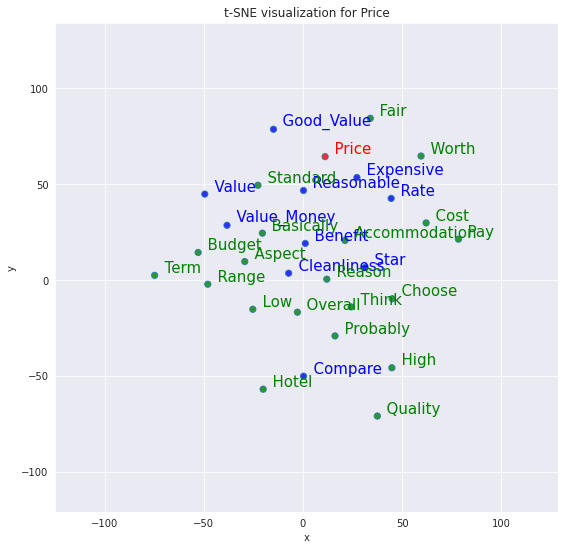

In [110]:
tsnescatterplot(w2v_model, 'price',[t[0] for t in w2v_model.wv.most_similar(positive=["price"], topn=30)][10:])

**Vamos ver se funciona com outras palavras**

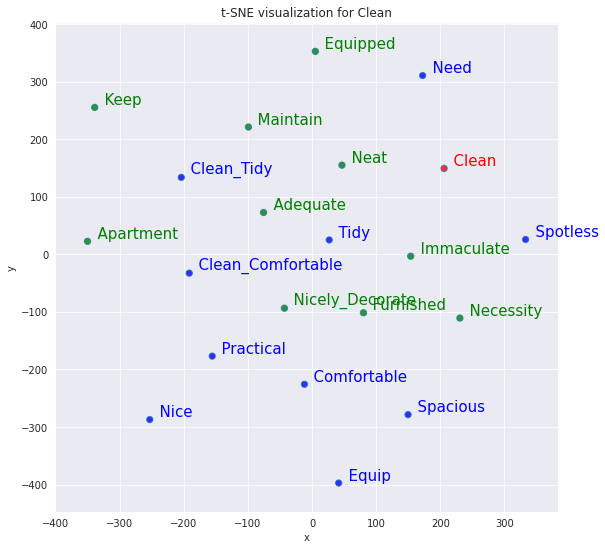

In [111]:
tsnescatterplot(w2v_model, 'clean',[t[0] for t in w2v_model.wv.most_similar(positive=["clean"], topn=20)][10:])

está novamente dando ótimos resultados.

vamos ver se funciona para algo aleatório

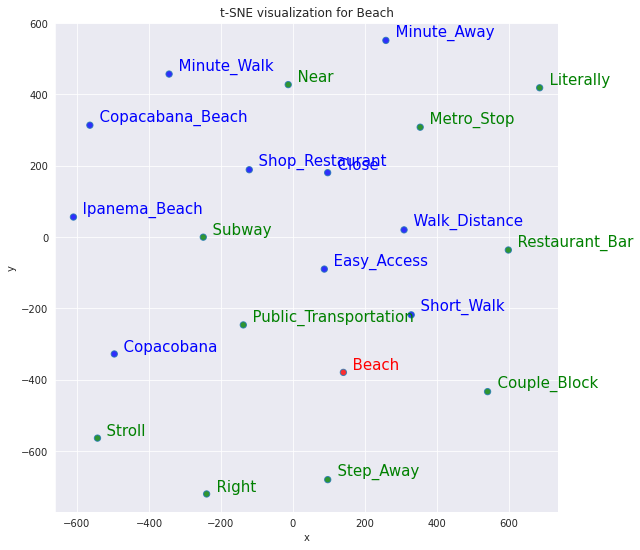

In [112]:
tsnescatterplot(w2v_model, 'beach',[t[0] for t in w2v_model.wv.most_similar(positive=["beach"], topn=20)][10:])